In [1]:
cd ../

/Users/tombutler/Documents/ai-hackathon


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score


import seaborn as sns
import matplotlib.pyplot as plt

from data.processed.pre_process_titanic import pre_process_df
from plots.plt_compare_distributions import gen_histograms


%load_ext lab_black

In [3]:
TRAIN_DATA_PATH = "data/raw/train.csv"
TEST_DATA_PATH = "data/raw/test.csv"
FAKE_DATA_PATH = "data/fake/tabgan_data.csv"
NUM_COLUMNS = ["Fare", "Age"]
CAT_COLUMNS = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
LABEL = "Survived"
COLUMNS = NUM_COLUMNS + CAT_COLUMNS

### 1. Load in the data and prepare it

In [4]:
# Load the Titanic dataset
train = pre_process_df(TRAIN_DATA_PATH)[COLUMNS]
target = pd.read_csv(TRAIN_DATA_PATH)[[LABEL]]
test = pre_process_df(TEST_DATA_PATH)[COLUMNS]

fake = pd.read_csv(FAKE_DATA_PATH)

In [5]:
# Impute missing values
imputer = SimpleImputer(strategy="median")
train = pd.DataFrame(imputer.fit_transform(train), columns=COLUMNS)
test = pd.DataFrame(imputer.fit_transform(test), columns=COLUMNS)

### 2. Extract a test set, and set up the real and fake features and targets

In [6]:
X = train[COLUMNS].copy()
y = target.copy()

In [7]:
X_train_real, X_test, y_train_real, y_test = train_test_split(X, y, stratify=y)

In [8]:
X_train_fake = fake[COLUMNS].copy()
y_train_fake = fake[LABEL].copy()

### 3. Train the models

In [9]:
model_real = LGBMClassifier(n_estimators=100, max_depth=5, random_state=1)
model_real.fit(X_train_real, y_train_real)
proba_real = model_real.predict_proba(X_test)
predictions_real = model_real.predict(X_test)

/Users/tombutler/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tombutler/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [10]:
model_fake = LGBMClassifier(n_estimators=100, max_depth=5, random_state=1)
model_fake.fit(X_train_fake, y_train_fake)
proba_fake = model_fake.predict_proba(X_test)
predictions_fake = model_fake.predict(X_test)

### 4. Compare the models

In [11]:
def get_metrics(y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    return {"accuracy": accuracy, "precision": precision, "recall": recall}

In [12]:
metrics_real = get_metrics(y_test, predictions_real)
metrics_fake = get_metrics(y_test, predictions_fake)

In [21]:
len(X_train_fake) / len(X_train_real)

3.872754491017964

In [13]:
metrics_real

{'accuracy': 0.8116591928251121,
 'precision': 0.8055555555555556,
 'recall': 0.6744186046511628}

In [14]:
metrics_fake

{'accuracy': 0.8475336322869955,
 'precision': 0.90625,
 'recall': 0.6744186046511628}

In [15]:
scores_real_df = pd.DataFrame(
    zip(y_test.values[:, 0], proba_real[:, 1], predictions_real),
    columns=[LABEL, "proba", "pred"],
)

scores_fake_df = pd.DataFrame(
    zip(y_test.values[:, 0], proba_fake[:, 1], predictions_fake),
    columns=[LABEL, "proba", "pred"],
)

In [16]:
scores_real_df["model"] = "real"
scores_fake_df["model"] = "fake"

<Axes: xlabel='proba', ylabel='Density'>

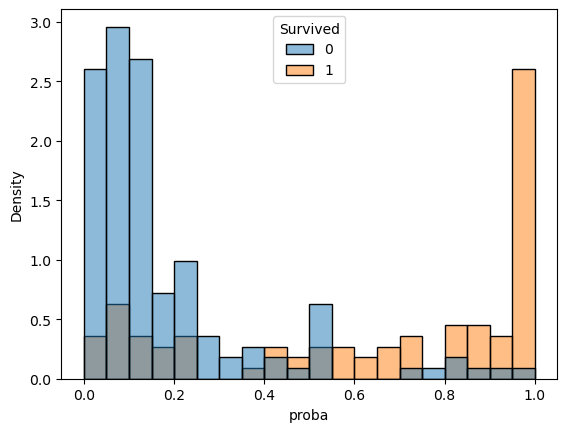

In [17]:
sns.histplot(
    data=scores_real_df,
    x="proba",
    stat="density",
    hue=LABEL,
    bins=[0.05 * x for x in range(21)],
)

<Axes: xlabel='proba', ylabel='Density'>

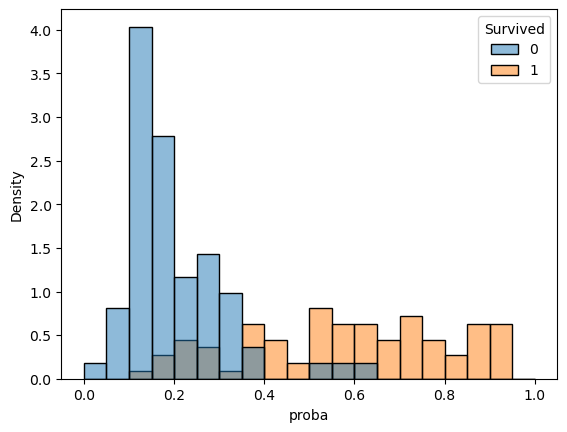

In [18]:
sns.histplot(
    data=scores_fake_df,
    x="proba",
    stat="density",
    hue=LABEL,
    bins=[0.05 * x for x in range(21)],
)

In [19]:
scores_df = pd.concat([scores_real_df, scores_fake_df])

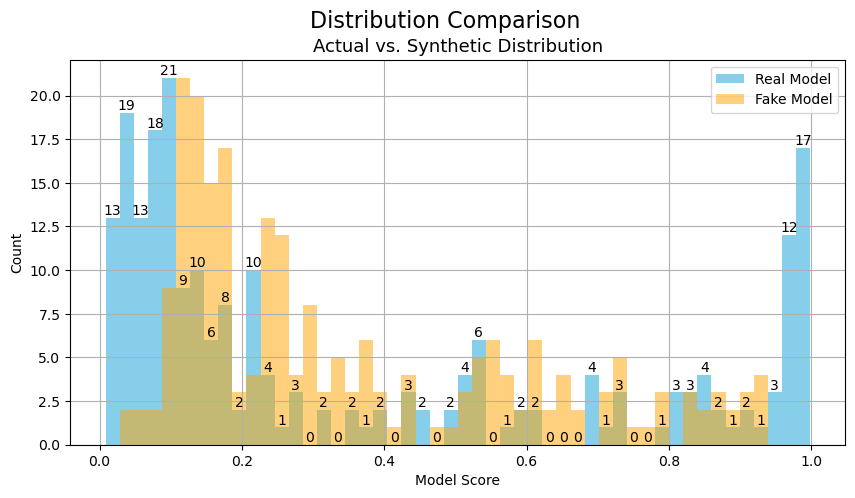

In [20]:
f = gen_histograms(
    scores_df.query("model=='real'")["proba"],
    scores_df.query("model=='fake'")["proba"],
    labels=["Real Model", "Fake Model"],
    x_label="Model Score",
    y_label="Count",
)